<a href="https://colab.research.google.com/github/wjs20/OAS_data_mining/blob/main/peds_paper_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture 
%pip install biopython 

In [ ]:
from pathlib import Path
import numpy as np
import torch
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import random
import sys
import re
import pandas as pd
import requests
import re
import json
import gzip
import shutil
import urllib.request
import os
from tqdm.auto import tqdm
from bs4 import BeautifulSoup

In [ ]:
# import peds paper library
sys.path.append('/content/drive/MyDrive/peds2019')
from lstm_bi import LSTM_Bi
from ablstm import ModelLSTM
from utils_data import ProteinSeqDataset, aa2id_i, aa2id_o, collate_fn

In [ ]:
# create path variables
DRIVE = Path()/'drive'/'MyDrive'
MODEL_PATH = DRIVE/'models'
DATA_PATH = DRIVE/'data'

In [ ]:
class OASDownloader:
    def __init__(self, url): self.url = url

    def is_link(self, link): 
        return re.search('^[\?/]', link.get('href')) is None

    def download_json(self, url, study):
        url_path, study = Path(url), Path(study)
        if not study.exists(): study.mkdir()
        urllib.request.urlretrieve(url, study / url_path.name)
        with gzip.open(study / url_path.name, 'rb') as f_in:
            with open(study / url_path.stem, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

    def clear_gz(self, study):
        p = Path()/study
        gz_files = list(p.glob('**/*.gz'))
        for gz in gz_files: gz.unlink()
    
    def ls_studies(self): return self.get_links(self.url)
    
    def ls_links(self, study): return self.get_links(self.url + study)
    
    def get_links(self, url):
        page = requests.get(url)
        html = page.text
        soup = BeautifulSoup(html, 'html.parser')
        return [link.get('href') for link in soup.find_all('a') if self.is_link(link)]

    def download(self, study):
        links = self.get_links(self.url + study)
        full_urls = [self.url + study + link for link in links]
        for url in tqdm(full_urls): self.download_json(url, study)
        self.clear_gz(study)
    
class OASDataset:
    def __init__(self, path): 
        self.path = Path(path)

    # lists the different conditions/individuals in the study 
    def ls_entries(self, full_path=False): 
        return [p if full_path else p.name.strip('.json') for p in self.path.iterdir()]

    # extracts seqs and writes them to a txt file from which seqs can be randomly sampled
    def write_seqs(self, entries=None):
        if entries is None: entries = self.ls_entries(full_path=True)
        with open(self.path/'seqs.txt', 'a') as f:
            for entry in tqdm(entries):
                data = [json.loads(line) for line in open(entry)]
                for d in data[1:]: f.write(d['seq'] + '\n')
    
    # loading sequences into memory may use a large amount of memory if the sequence files are large 
    def load_data(self, entries=None):
        if entries is None: entries = self.ls_entries(full_path=True)
        self.data = {entry.name.strip('.json'): [json.loads(line) for line in open(entry)] for entry in tqdm(entries)}
    
    # extract sequences into a list
    def get_seqs(self):
        seqs = []
        for v in tqdm(self.data.values()): seqs.extend([i['seq'] for i in v if 'seq' in i.keys()])
        return list(set(seqs))


def write_fasta(seqs, path, name):
    seq_records = [SeqRecord(Seq(seq)) for seq in seqs]
    SeqIO.write(seq_records, path/f'{name}.fasta', 'fasta')

def read_fasta(path, size=None):
    seqs = [str(sr.seq) for sr in SeqIO.parse(path, 'fasta')]
    if size is None: return seqs 
    return random.sample(seqs, size)

def write_train_test(path, train_size=25_000, valid_size=10_000, overwrite=False):
    if (path/'train.txt').exists() and not overwrite: return
    fasta = list(path.glob('*97.fasta'))[0]
    seqs = read_fasta(fasta)
    train, remain = train_test_split(seqs, train_size=train_size, random_state=42)
    valid, test = train_test_split(remain, train_size=valid_size, random_state=42)
    for fname, split in zip(['train', 'valid', 'test'], [train, valid, test]):
        with open(path/f'{fname}.txt', 'w') as f: 
            for line in split: f.write(line + '\n')

def fit_peds_model(path, save=True, n_epochs=10):
    model.fit(path/'train.txt', path/'valid.txt', n_epoch=n_epochs, trn_batch_size=128, vld_batch_size=512, lr=.002, save_fp=None)
    if save: model.save(fn=MODEL_PATH/'model_tmp.npy')

def load_peds_model():
    MODEL = 'model_tmp.npy'
    model_loaded = ModelLSTM()
    model_loaded.load(fn=MODEL_PATH/MODEL)
    return model_loaded


In [ ]:
model = load_peds_model()
# model = ModelLSTM(embedding_dim=64, hidden_dim=64, device='cpu', gapped=False, fixed_len=False)

In [ ]:
# url = 'http://opig.stats.ox.ac.uk/webapps/ngsdb/json/'
# downloader = OASDownloader(url)
# downloader.download('Waltari_2018/')
# downloader.clear_gz('Waltari_2018/')
# waltari = OASDataset('Waltari_2018/')
# waltari.write_seqs()

In [ ]:
# with open(DATA_PATH/'waltari'/'seqs_downsample.txt') as f:
#     seqs = [seq.strip() for seq in f.readlines()]

WALTARI = DATA_PATH/'waltari'
# write_fasta(seqs, WALTARI, 'human')

# -> run cd-hit algorithm to cluster sequences at 97%
# write_train_test(WALTARI)

In [ ]:
#fit_peds_model(WALTARI)

          (VLD): 100%|| 10000/10000 [00:11<00:00, 886.90seq/s, loss=0.598725, acc=0.851378]


In [ ]:
studies = {'collins': 'mouse', 'li': 'camel', 'corcoran': 'macaque', 'waltari': 'human'}

# for study in tqdm(studies.keys()):
#     write_train_test(DATA_PATH/study)

In [ ]:
def get_lstm_score(study, species):
    '''
    function takes as input a txt file containing sequences 
    from a species of interest and returns a pandas dataframe 
    containing the sequences, species of origin and LSTM scores
    '''
    with open(DATA_PATH/study/'valid.txt') as f:
        seqs = [s.strip() for s in f.readlines()]
    scores = model.eval(DATA_PATH/study/'valid.txt')
    data = zip(seqs, [species]*len(seqs), scores)
    columns = ['seqs', 'species', 'lstm_scores']
    return pd.DataFrame(data, columns=columns)

In [ ]:
# score sequences from all species and store in dataframe 
lstm_scores = pd.concat([get_lstm_score(k, v) for k, v in studies.items()])

100%|| 10000/10000 [00:11<00:00, 898.80seq/s]


In [ ]:
#lstm_scores.to_csv(DATA_PATH/'lstm_scores.csv', index=False)

In [ ]:
scores = pd.read_csv(DATA_PATH/'scores.csv')

In [ ]:
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15}) 

In [ ]:
def save_fig(fname):
    plt.savefig(DRIVE/'figures'/fname, format='svg', dpi=1000)    

Text(0.5, 12.2, 'LSTM scores')

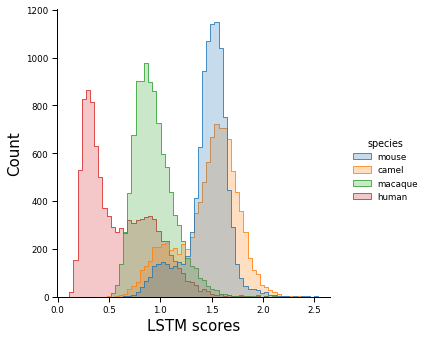

In [ ]:
sns.displot(lstm_scores, x='lstm_scores', hue='species', element='step')
plt.xlabel('LSTM scores')
#save_fig('lstm_score_distribution.svg')

In [ ]:
from sklearn.metrics import roc_curve

def get_preds(df, spec):
    labels = {'human': 0, spec: 1}
    rows = df[df['species'].isin(['human', spec])].loc[:, ['lstm_scores', 'species']].values
    y = np.array([labels[o] for o in rows[:,1]])
    y_pred = rows[:,0]
    return y_pred, y

def plot_preds(df, spec, col):
    y_pred, y = get_preds(df, spec)
    fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1)
    plt.plot(fpr, tpr, col, label=spec)
    plt.xlabel('False positive rate')    
    plt.ylabel('True positive rate')    
    plt.legend()

In [ ]:
from sklearn.metrics import roc_auc_score

def get_auc_score(df, spec):
    y_pred, y = get_preds(df, spec)
    return roc_auc_score(y, y_pred)    

for spec in ['mouse', 'camel', 'macaque']:
    print(get_auc_score(lstm_scores, spec))

0.979701995
0.96639023
0.801306345


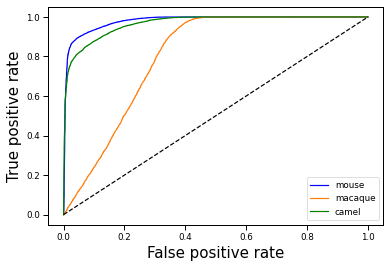

In [ ]:
specs = ['mouse', 'macaque', 'camel']
colours = ['b', 'tab:orange', 'g']
for spec, col in zip(specs, colours): plot_preds(scores, spec, col)
plt.plot([0, 1], [0, 1], 'k--');
save_fig('roc_auc_plot.svg')

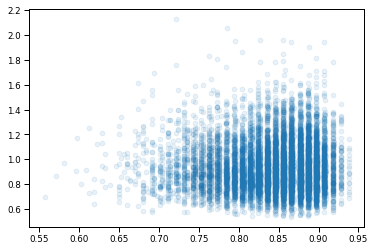

In [ ]:
def correlate_scores(df, species, plot=True):
    rows = df['species']==species
    y = df[rows].lstm_scores.values
    x = df[rows].alignment_score.values
    if not plot: return np.corrcoef(x, y)
    plt.scatter(x, y, alpha=0.1)
    plt.show()

correlate_scores(scores, 'macaque', plot=True)